In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score


**Step 1:** Upload the preprocessed data that contains only form names and fieldlabels

In [2]:
df = pd.read_csv('data/all_data.csv', on_bad_lines='skip')

#handle blocktype(removeit).
indices_to_drop = df[df['elementtype'] == 'block'].index
df = df.drop(indices_to_drop)

#put specialtype in place.
for index, row in df.iterrows():
    if row['elementtype'] == 'special' and pd.isnull(row['fieldtype']):  # Check if 'elementtype' is empty
        df.at[index, 'fieldtype'] = row['specialtype']  # Assign 'specialtype' value to 'elementtype'

df = df.drop(columns=['Kunde', 'fieldtype','specialtype','elementtype', 'customname','fieldobjectid','fieldparentid','fieldparenttype','blocktype','fieldrelation','language'])
display(df)

,customform,name,fieldlabel
0,876,Kundereklamation,Vælg kunde
2,876,Kundereklamation,Gadenavn
3,876,Kundereklamation,Postnr
4,876,Kundereklamation,By
5,876,Kundereklamation,Telefonnummer
...,...,...,...
10330,2386659,Intern IT Support,"Registrerer du tid, kan du bruge flg. opg.nr: ..."
10331,1927875,Azure - Udløb af client secret,Ansvarlig for opsætning
10333,1329139,Leverancer,Installationen oprettes på domænet xxxx.ipw.dk
10334,1329139,Leverancer,Installationen oprettes på domænet <b>xxxx.ipw...


**Step 2:** Additional step in data preprocessing is concatinatting all fieldlabels to a form name so that they stand all together per form name

In [3]:
# Step 1: Group by 'Form name' and aggregate the field labels into a list
grouped = df.groupby('name')['fieldlabel'].apply(list).reset_index()

# Step 2: Expand the lists into separate columns (using pd.DataFrame to handle different numbers of labels)
expanded = pd.DataFrame(grouped['fieldlabel'].tolist())

# Step 3: Combine the 'Form name' column with the expanded field labels
result = pd.concat([grouped['name'], expanded], axis=1)

# Step 4: Rename the columns appropriately
result.columns = ['name'] + [f'fieldlabel {i+1}' for i in range(result.shape[1] - 1)]

display(result)

,name,fieldlabel 1,fieldlabel 2,fieldlabel 3,fieldlabel 4,fieldlabel 5,fieldlabel 6,fieldlabel 7,fieldlabel 8,fieldlabel 9,...,fieldlabel 245,fieldlabel 246,fieldlabel 247,fieldlabel 248,fieldlabel 249,fieldlabel 250,fieldlabel 251,fieldlabel 252,fieldlabel 253,fieldlabel 254
0,*_270224_OBT - Alarmering,Emne,Link,Læst og forstået,Ikke forstået,Instruktør,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,*_270224_OBT - Andet,Emne,Link,Ikke forstået,Læst og forstået,Instruktør,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,*_270224_OBT - Beredskab,Link,Emne,Instruktør,Ikke forstået,Læst og forstået,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,*_270224_OBT - Brandbekæmpelse,Link,Emne,Instruktør,Ikke forstået,Læst og forstået,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,*_270224_OBT - Førstehjælp og udstyr,Link,Emne,Instruktør,Ikke forstået,Læst og forstået,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,amnj-kundereklamation,Kunde navn,Gadenavn,Post nr.,By,Tlf. nr.,E-mail,Reklamations nr.,Kontaktperson,Vare nr.,...,None,None,None,None,None,None,None,None,None,None
833,amnj-leverandørreklamation,Reklamations nr.,Leverandørnavn,Gadenavn,Post nr.,By,Tlf. nr.,E-mail,Kontaktperson,Vare nr.,...,None,None,None,None,None,None,None,None,None,None
834,decimaltester,Input 1,Input 2,Output,Audit inspection score,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
835,nj test create,opret,tjekboks,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [4]:
from sklearn.feature_extraction import FeatureHasher
import matplotlib.pyplot as plt

X_df = pd.DataFrame(result)

#print(X_df)

# Concatenate 'name' with all 'fieldlabel' columns, replacing None with 'None'
X_df['concatenated'] = X_df.apply(
    lambda row: row['name'] + " " + " ".join(
        [str(row[f'fieldlabel {i}']) if row[f'fieldlabel {i}'] is not None else '' for i in range(1, 6)]
    ), axis=1
)

print(X_df['concatenated'])

# Create a CountVectorizer to convert form names into vectors
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X_df['concatenated'])

# View the result as an array
print(X_vectorized.toarray())

0      *_270224_OBT - Alarmering Emne Link Læst og fo...
1      *_270224_OBT - Andet Emne Link Ikke forstået L...
2      *_270224_OBT - Beredskab Link Emne Instruktør ...
3      *_270224_OBT - Brandbekæmpelse Link Emne Instr...
4      *_270224_OBT - Førstehjælp og udstyr Link Emne...
                             ...                        
832    amnj-kundereklamation Kunde navn Gadenavn Post...
833    amnj-leverandørreklamation Reklamations nr. Le...
834    decimaltester Input 1 Input 2 Output Audit ins...
835                     nj test create opret tjekboks   
836    Årshjulet Nr. Aktivitet Ansvarlig Antal månede...
Name: concatenated, Length: 837, dtype: object
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


As the data is Nominal, and as we turn our categorical points into nominal since we want to concatenate Form name with Field Labels, we used the Bag of Words (CountVectorizer) to make the data into numerical.

**Step 3:** Create the clusters

We will try a few distances.
The first distance is Hamming Distance.
One of its requirements is that the data can't be sparse, thus why we turn the vectorized data into a dense matrix.
Reasoning for using Hamming Distance was none. The choice of distances used in this experiment were mostly random as to try find a potential solution that could have passed through our mind.
In fact, Hamming Distance is better for Categorical data or Binary data.
We also reduce the data using PCA as to visualize it in the plot.

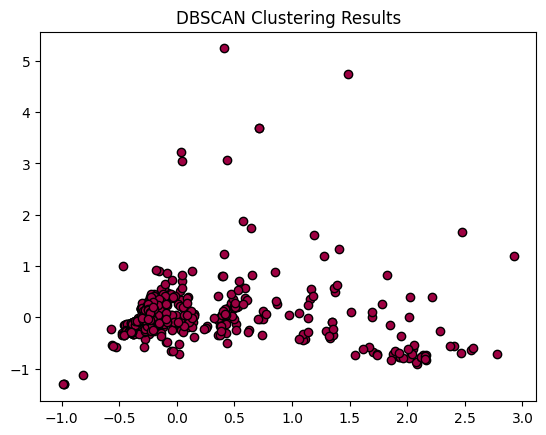

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances

# Convert the sparse matrix to a dense matrix
X_dense = X_vectorized.toarray()

# Calculate Hamming distance directly
db = DBSCAN(eps=0.5, min_samples=5, metric='hamming')
db.fit(X_dense)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Extract the labels assigned by DBSCAN (-1 indicates noise points)
labels = db.labels_

# Reduce the dimensionality of the data to 2D using PCA if needed for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_dense)

# Plot the DBSCAN clustering result
unique_labels = np.unique(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise points
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = reduced_data[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), 
             markeredgecolor='k', markersize=6)

plt.title('DBSCAN Clustering Results')
plt.show()

This time we use the Euclidean Distance.
A more fitting distance for our type of data, as its good for continuous and numerical data.
Doesn't require any extra changes on the data like the Hamming distance with its dense matrix.

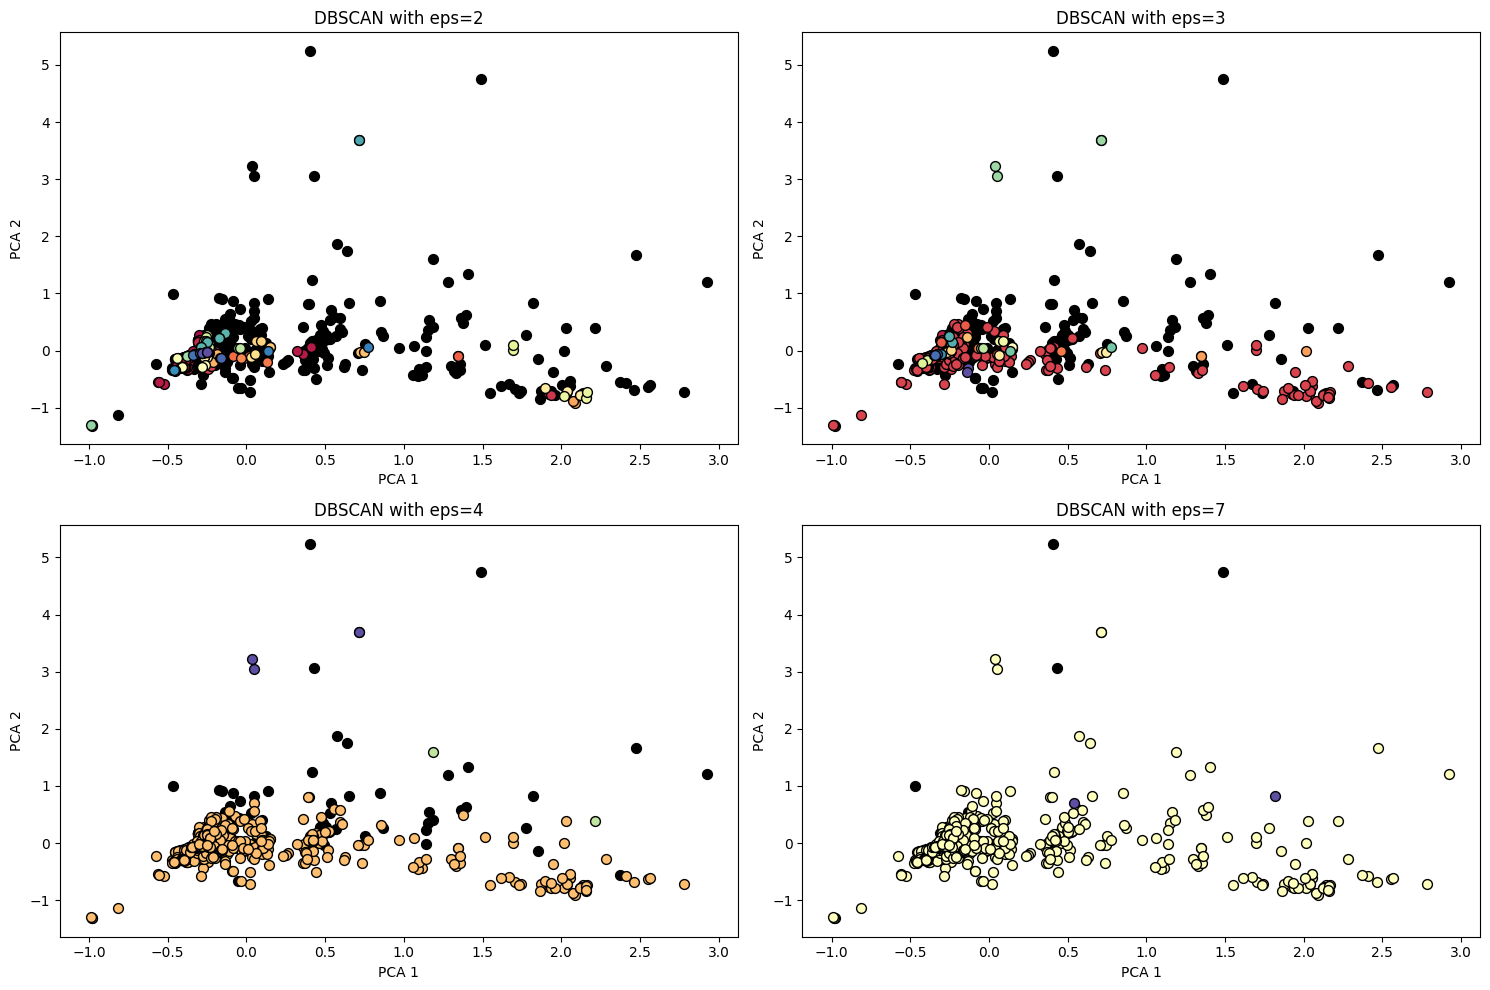

In [10]:
from sklearn.metrics.pairwise import pairwise_distances

# Perform PCA to reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_vectorized)

# Define a range of eps values to try
eps_values = [2, 3, 4, 7]

# Set up the plot grid
plt.figure(figsize=(15, 10))

for i, eps in enumerate(eps_values, 1):
    # Apply DBSCAN with different eps values
    db = DBSCAN(eps=eps, min_samples=2, metric='euclidean')
    labels = db.fit_predict(X_dense)
    
    # Create a scatter plot for the current DBSCAN result
    plt.subplot(2, len(eps_values)//2, i)
    unique_labels = np.unique(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]  # Black for noise points
        
        class_member_mask = (labels == k)
        xy = reduced_data[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], c=[tuple(col)], edgecolor='k', s=50)

    plt.title(f'DBSCAN with eps={eps}')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()

The Euclidean distance, even though has better results than Hamming, is still filled with false outliars. It also seems to have difficulty in finding clusters. 

The last distance used is the Cosine Similiarity distance.
It works well with Bag of Words data, due to its nature of calculating the similarity of 2 points through their angle and which direction a vector is pointing to.
Did not require any kind of extra proccessing of the data unlike Hamming.

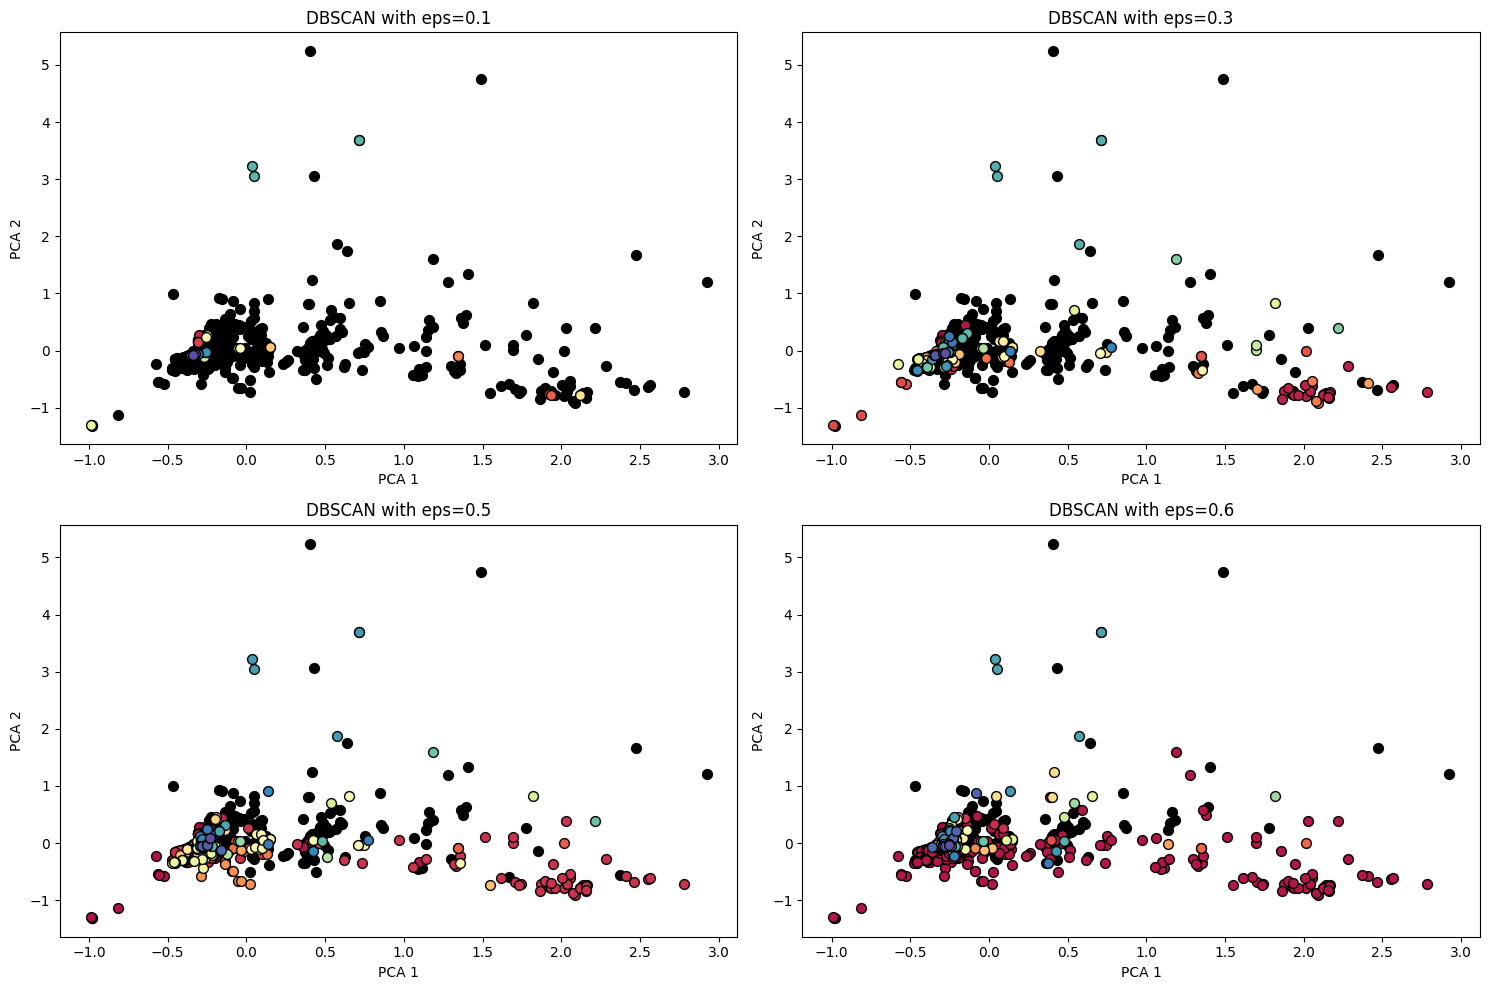

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer

# Perform PCA to reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_vectorized)

# Define a range of eps values to try
eps_values = [0.1, 0.3, 0.5, 0.6]

# Set up the plot grid
plt.figure(figsize=(15, 10))

for i, eps in enumerate(eps_values, 1):
    # Apply DBSCAN with different eps values
    db = DBSCAN(eps=eps, min_samples=2, metric='cosine')
    labels = db.fit_predict(X_dense)
    
    # Create a scatter plot for the current DBSCAN result
    plt.subplot(2, len(eps_values)//2, i)
    unique_labels = np.unique(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]  # Black for noise points
        
        class_member_mask = (labels == k)
        xy = reduced_data[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], c=[tuple(col)], edgecolor='k', s=50)

    plt.title(f'DBSCAN with eps={eps}')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()


The results of Cosine Distance show that it seems to be the best choice if we were to use DBScan as our clustering model. There are still many outliars, with a high likelihood some of them are false outliars, but there is at least some form of "clusters" show.

Overall, after the entire experiment, it is obvious that DBScan is not good enough to cluster our specific data, and some changes are required if we are to approach a clustering path for this project.